In [39]:
%matplotlib inline
import os
import nltk
import regex
import pymystem3
import collections
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from lxml import etree

## Чтение данных

In [40]:
data_dir = "../data/text_alignment/"
train_path = data_dir + "tasks"

In [41]:
data_dir = "../data/pan13-text-alignment-training-corpus-2013-01-21/"
#train_path = data_dir + "tasks"
#train_path = data_dir + "tasks/03-random-obfuscation"
#train_path = data_dir + "tasks/04-translation-obfuscation"
train_path = data_dir + "tasks/05-summary-obfuscation"

In [54]:
data_dir ="../data/pan13-text-alignment-test-corpus2-2013-01-21/"
train_path = data_dir + "tasks/01-no-plagiarism"
#train_path = data_dir + "tasks/02-no-obfuscation"
#train_path = data_dir + "tasks/03-random-obfuscation"
#train_path = data_dir + "tasks/04-translation-obfuscation"
#train_path = data_dir + "tasks/05-summary-obfuscation"

In [42]:
xmls_paths = list(filter(lambda f: f.endswith(".xml"), os.listdir(train_path)))

In [43]:
%%time

train_data = []

for xml_path in xmls_paths:
    train_xml_path = os.path.join(train_path, xml_path)
    xml_root = etree.parse(train_xml_path)
    suspicious_path = xml_root.getroot().attrib["reference"]
    suspicious_text = open(os.path.join(data_dir, "susp", suspicious_path)).read()
    for feature in xml_root.xpath("feature"):
        train_row = {}
        if feature.attrib["name"] != "plagiarism":
            continue
        # Read raw data
        suspicious_offset = int(feature.attrib["this_offset"])
        suspicious_length = int(feature.attrib["this_length"])
        source_offset = int(feature.attrib["source_offset"])
        source_length = int(feature.attrib["source_length"])
        source_path = feature.attrib["source_reference"]
        # Set df values
        train_row["obfuscation"] = feature.attrib["type"]
        train_row["suspicious_path"] = suspicious_path
        train_row["suspicious_offset"] = suspicious_offset
        train_row["suspicious_length"] = suspicious_length
        train_row["source_path"] = source_path
        train_row["source_offset"] = source_offset
        train_row["source_length"] = source_length
        # Read texts and set values
        source_text = open(os.path.join(data_dir, "src", source_path)).read()
        train_row["suspicious_text"] = suspicious_text[suspicious_offset : suspicious_offset + suspicious_length]
        train_row["source_text"] = source_text[source_offset : source_offset + source_length]
        train_data.append(train_row)

CPU times: user 243 ms, sys: 56 ms, total: 299 ms
Wall time: 426 ms


In [44]:
train_df = pd.DataFrame(train_data)

In [45]:
len(train_df)

238

In [46]:
%time train_df.to_csv("pan_train_texts.csv")

CPU times: user 77 ms, sys: 3 ms, total: 80 ms
Wall time: 82.5 ms


## Изучение данных

In [9]:
len(train_data)

76125

In [10]:
train_df[["obfuscation", "source_path", "source_text", "suspicious_path", "suspicious_text"]].head(20)

,obfuscation,source_path,source_text,suspicious_path,suspicious_text
0,manual,3182571.txt,"МОНДРИАН, ПИТ (наст. имя Питер Корнелис) (Mond...",043.txt,Пит Мондриан (наст.имя Питер Корнелис) (1872–1...
1,manual,3182571.txt,"В 1911 он познакомился с кубистами, и их творч...",043.txt,Вскоре после знакомства с кубистами в 1911 год...
2,manual,3182571.txt,Вскоре Мондриан отказался в своих картинах от ...,043.txt,Вскоре после знакомства с кубистами в 1911 год...
3,manual,3182571.txt,В 1912—1916 он строил композиции на основе сво...,043.txt,В 1912—1916 он строил композиции на основе сво...
4,manual,3182571.txt,"В это время Мондриан, подобно Жоржу Браку и Па...",043.txt,В 1912—1916 он строил композиции на основе сво...
5,manual,3182571.txt,К 1920 стиль Мондриана полностью сформировался.,043.txt,К 1920 стиль Мондриана полностью сформировался...
6,manual,3182571.txt,"Используя прямые линии жестких контуров, он де...",043.txt,К 1920 стиль Мондриана полностью сформировался...
7,manual,3182571.txt,Мондриан еще больше сократил свои художественн...,043.txt,К 1920 стиль Мондриана полностью сформировался...
8,manual,3182571.txt,Умер Мондриан в Нью-Йорке 1 февраля 1944.,043.txt,Мондриан скончался в Нью-Йорке 1 февраля 1944.
9,manual,3182571.txt,Его произведения оказали влияние на многих сов...,043.txt,Его произведения оказали влияние на многих сов...


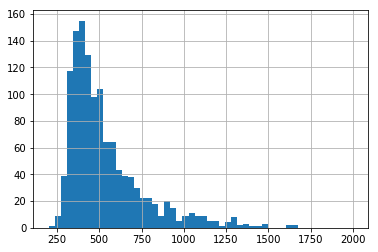

In [27]:
train_df["source_length"].hist(bins=50, range=(200, 2000))

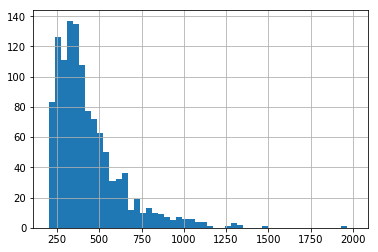

In [28]:
train_df["suspicious_length"].hist(bins=50, range=(200, 2000))

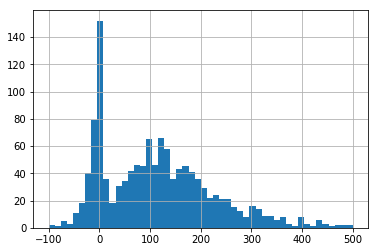

In [29]:
(train_df["source_length"] - train_df["suspicious_length"]).hist(bins=50, range=(-100, 500))

---

In [30]:
train_df[train_df["obfuscation"] == "LPR"]

,obfuscation,source_length,source_offset,source_path,source_text,suspicious_length,suspicious_offset,suspicious_path,suspicious_text


In [31]:
train_df[train_df["obfuscation"] == "LPR"]

,obfuscation,source_length,source_offset,source_path,source_text,suspicious_length,suspicious_offset,suspicious_path,suspicious_text


---

**Распределение типов плагиата**

In [32]:
collections.Counter(train_df["obfuscation"]).most_common(25)

[('artificial', 1267)]

---

In [33]:
## Гипотеза: заимствования состоят из одинакового числа предложений.

dots_diff = train_df["suspicious_text"].apply(lambda s: s.count("\n")) - \
            train_df["source_text"].apply(lambda s: s.count("\n"))

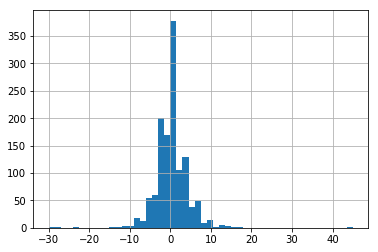

In [34]:
dots_diff.hist(bins=50)

In [35]:
dots_diff.min()

-30

In [36]:
dots_diff.max()

45

In [37]:
len(dots_diff[dots_diff == 0]) / len(dots_diff)

0.164956590370955

In [38]:
len(dots_diff[dots_diff != 0])

1058

In [39]:
dots_diff[dots_diff == dots_diff.min()]

531   -30
dtype: int64

In [40]:
dots_diff[dots_diff == dots_diff.max()]

513    45
dtype: int64

In [41]:
def show_texts(plag_id):
    obj = train_df.loc[plag_id]
    print("Plagiat type:", obj["obfuscation"])
    print("susp/" + obj["suspicious_path"] + " : " + repr(obj["suspicious_text"]))
    print("src/"+ obj["source_path"] + " : " + repr(obj["source_text"]))

In [42]:
# Word tokenization.

token_regexp = regex.compile("(?u)\\b(\\p{L}+|\d+)\\b")

def tokenize(text):
    return token_regexp.findall(text)

In [43]:
def jaccard_dist(l1, l2):
    s1, s2 = set(l1), set(l2)
    if len(s1) == 0 and len(s2) == 0:
        return 1
    else:
        return 1 - len(s1 & s2) / len(s1 | s2)

In [44]:
f = lambda x: jaccard_dist(tokenize(train_df.loc[x]["source_text"]), tokenize(train_df.loc[x]["suspicious_text"]))

In [45]:
f(42)

0.5602836879432624

In [46]:
show_texts(2)

Plagiat type: artificial
susp/suspicious-document01386.txt : 'S KoulopoulosDestination Imagination Parents work with small groups of pupil to develop their original\ntalents and create an imaginative acting based in\xa0 theme. Students also enter in the state-wide competition. A-a Middle School teachersexchange City, NH Students get a sensation on what it\x19 Tom like of\xa0 real world during this six-week program. '
src/source-document01819.txt : 'Tom KoulopoulosDestination Imagination\nParents work with small groups of students to develop their imaginative talents and create an original skit based on a theme. Students also participate in a state-wide competition.\n\xa0-\xa0Middle School TeachersExchange City, NH\nStudents get a taste of what it\x19s like in the real world during this six-week program.'


In [68]:
# Sentence tokenization.

sent_detector = nltk.data.load("tokenizers/punkt/english.pickle")
max_short_len = 3

def sent_tokenize(text):
    # Basic preprocessing.
    text = text.lower()

    # Step 1: generate sentences and spans.
    sentences = [tokenize(x) for x in sent_detector.tokenize(text)]
    spans = sent_detector.span_tokenize(text)

    # Step 2: concatenate short sentences.
    out_sentences = []
    out_spans = []
    short_sentence = []
    short_span = None
    for sent, span in zip(sentences, spans):
        if short_span:
            short_sentence += sent
            short_span = (short_span[0], span[1])
        elif len(sent) <= max_short_len:
            short_sentence = sent
            short_span = span
        if len(sent) > max_short_len:
            if short_span:
                out_sentences.append(short_sentence)
                out_spans.append(short_span)
                short_sentence = []
                short_span = None
            else:
                out_sentences.append(sent)
                out_spans.append(span)
    if short_span:
        out_sentences.append(short_sentence)
        out_spans.append(short_span)

    return out_sentences, out_spans

In [69]:
sent_tokenize(train_df.loc[19]["source_text"])

([['the',
   'drive',
   'from',
   'san',
   'juan',
   'is',
   'on',
   'a',
   'modern',
   'toll',
   'highway',
   'and',
   'the',
   'style',
   'of',
   'driving',
   'is',
   'similar',
   'to',
   'any',
   'large',
   'metropolitan',
   'area',
   'in',
   'the',
   'mainland',
   'usa'],
  ['note',
   'most',
   'drivers',
   'in',
   'puerto',
   'rico',
   'do',
   'not',
   'use',
   'their',
   'directional',
   'signals',
   'so',
   'don',
   't',
   'be',
   'surprised',
   'if',
   'cars',
   'turn',
   'without',
   'notice'],
  ['once',
   'you',
   'reach',
   'aguadilla',
   'the',
   'road',
   'narrows',
   'and',
   'becomes',
   'a',
   '4',
   'lane',
   'road',
   'with',
   'stoplights',
   'along',
   'the',
   'way']],
 [(0, 139), (141, 264), (265, 364)])

## Задачи, которые хорошо бы сделать

1. Разобраться, как (и с какой сложностью) работает baseline-решение.

## Вопросы, которые предстоит решить

1. Что считать границами предложения? В 6.5% случаев нельзя делить по `\n`, пример `9291`.
2. Какая метрика качества будет использоваться для итоговой оценки?

## Проблемы с обучающей выборкой

1. Не полностью выделяются куски заимствований в source, пример -- `3844` и `9026`.

---